In [1]:
# default_exp directed_diffusion_maps 
from nbdev.showdoc import *
import numpy as np
from sklearn.metrics import pairwise_distances
import numpy as np
import scipy
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Perrault-Jonas2011's Directed Graph Embeddings
### Re-implemented for benchmarking against our techniques

[Perrault-Jonas 2011 - Directed Graph Embeddings](x-devonthink-item://58E9930C-8189-403E-8EF0-8D0D545EDA54) gives one compelling way to embed directed graphs. Whereas work on the Magnetic Laplacian and other means of working with directed graphs approaches the problem from a graph-theoretic viewpoint, Perrault and Jonas view the problem as a *manifold problem*: just as diffusion maps embed undirected graphs as if they are points drawn from a manifold, the proposed algorithm embeds points as if they come from a manifold covered by a flowing vector field.

Think of it as diffusion maps for manifolds with flow.

This approach has the merits of theoretical cleanliness, but inherits some practical issues from diffusion maps: 

1. The embedding of the points has *nothing to do* with the flow. Diffusion maps reproduce the manifold without any consideration of the directed information.

2. Diffusion coordinates are not optimized for visualization. Diffusion vectors represent branches of the manifold, but each branch is given its own dimension.

In [2]:
#export
import logging
def directed_diffusion_map(W, t = 1, kernel_type = "anisotropic", alpha = 0.5, sigma = "automatic", k = 10):
  
  Dists = distance_matrix(X)
  if sigma == "automatic":
    # Heuristic for sigma: median of the distance to the kth nearest neighbor
    sigma = np.median(np.partition(Dists,k)[:,k])
    print("using sigma = ",sigma)
  W = anisotropic_kernel(Dists, sigma=sigma, alpha = alpha)
  P_symmetric, D = diffusion_matrix(W, symmetric=True, return_degree=True)
  diff_map = diffusion_coordinates(P_symmetric, D, t = t)
  diff_map = diff_map[:,::-1]
  diff_map = diff_map.T
  return diff_map

## UW Directed Graph Embedding Algorithm

![UW Directed Embedding Algorithm](./images/UW_directed_embedding_alg.png)

In [3]:
"""
UW directed embedding algorithm
input: W affinity matrix, m embedding dimension
"""
def UW_directed_embedding(W, m):
    # steps 1-6 (estimate coordinates according to diffusion map)
    # step 1
    S = (W + np.transpose(W))/2 # symmetric affinity matrix

    # step 2
    q = np.sum(S, axis = 1)
    Q = np.diag(q) # degree matrix

    # step 3
    Qinv = np.linalg.inv(Q)
    V = Qinv@S@Qinv # anisotropic normalized affinity matrix

    # step 4
    q1 = np.sum(V, axis=1)
    Q1 = np.diag(q) # normalized degree matrix
    Q1inv = np.linalg.inv(Q1) # 
    
    # step 5
    Hss = Q1inv@V # diffusion matrix (dividing affinity matrix by row sums)

    # step 6
    eig_vals, eig_vecs = np.linalg.eig(Hss)
    idx = eig_vals.argsort()[::-1]
    eig_vals = eig_vals[idx]
    eig_vecs = eig_vecs[:,idx]

    phi = eig_vecs[:,:(m+1)] # first (m+1) right eigenvectors
    coords = eig_vecs[:,1:(m+1)] # first m significant right eigenvectors (coordinates of points in embedding)
    A = np.diag(eig_vals) # diagonal matrix of (m+1) significant eigenvalues


    # step 7-8: estimate the density
    density = 0.1
    """
    evals, evecs = scipy.linalg.eig(Hss, left = True, right = False)
    pi = evecs[np.where(evals == 1)] # left eigenvector of Hss with eigenvalue 1
    density = pi/sum(pi) # normalize
    """

    # step 9-13: estimate vector field r
    # step 9
    p = np.sum(W, axis = 1)
    P = np.diag(p)

    # step 10
    Pinv = np.linalg.inv(P)
    T = Pinv@W@Pinv
    p1 = np.sum(T, axis = 1)
    P1 = np.diag(p1)

    # step 11
    P1inv = np.linalg.inv(P1)
    Haa = P1@T

    R = ((Haa - Hss)@phi)
    fields = R[:,1:] # vector field components in the direction of the corresponding coordinates of the embedding

    return coords, density, fields

In [4]:
def visualize_UW_dir_emb(coords, density, fields):

    x = [a[0] for a in coords]
    y = [a[1] for a in coords]
    plt.scatter(x, y)
    plt.quiver(x, y, fields[:,0], fields[:,1])

### Algorithm on (Very Small) Toy Graphs

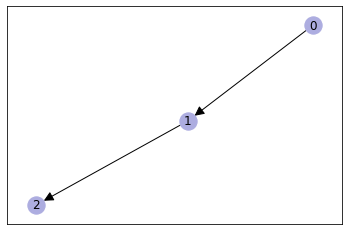

In [5]:
from directed_graphs.datasets import SmallRandom, visualize_graph, ChainGraph2, ChainGraph3
import torch_geometric
from torch_geometric.utils import to_networkx
dataset = ChainGraph2(num_nodes=3)
data = dataset[0]
visualize_graph(data)

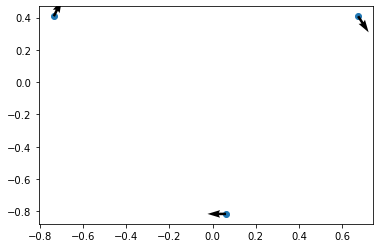

In [6]:
W = [[0, 1, 0],
     [0, 0, 1],
     [1, 0, 0]]

coords, density, fields = UW_directed_embedding(W, 2)

visualize_UW_dir_emb(coords, density, fields)

## UW-algorithm on Stochastic Block Model

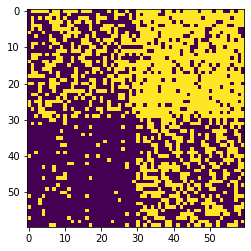

In [7]:
from directed_graphs.datasets import DirectedStochasticBlockModelHelper
from directed_graphs.datasets import visualize_heatmap
import torch

num_nodes = 60
num_clusters = 2

row = [0]
col = [1]
edge_index = torch.tensor([row, col])
data = DirectedStochasticBlockModelHelper(num_nodes=num_nodes, num_clusters=2, edge_index=edge_index, undir_prob=[0.9], dir_prob=[0.9])[0]

visualize_heatmap(data.edge_index)

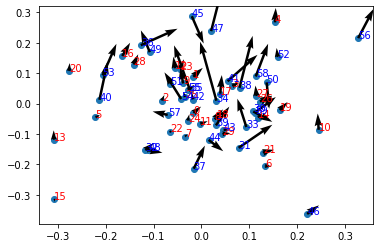

In [8]:
sparse_A = torch.sparse_coo_tensor(data.edge_index, torch.ones(data.edge_index.shape[1]))
A = sparse_A.to_dense()
A = A.numpy()
A = np.ndarray.tolist(A)

coords, density, fields = UW_directed_embedding(A, 2)
visualize_UW_dir_emb(coords, density, fields)
for i in range(int(len(coords)/2)):
    plt.text(coords[i][0], coords[i][1], i, color = "red")
for i in range(int(len(coords)/2), len(coords)):
    plt.text(coords[i][0], coords[i][1], i, color = "blue")

### More (Very Small) Toy Graphs

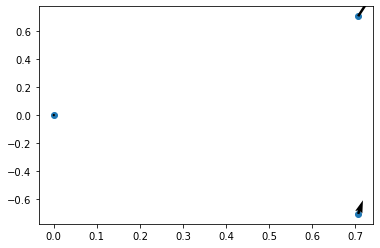

In [9]:
W = [[1,1,0],
     [0,1,0],
     [0,0,1]]
coords, density, fields = UW_directed_embedding(W, 2)
visualize_UW_dir_emb(coords, density, fields)

### More Stochastic Block Models, but better

In [10]:
from torch_geometric.data import Data, InMemoryDataset, download_url, extract_gz
from torch_geometric.utils import sort_edge_index
from torch_sparse import SparseTensor
from torch_geometric.utils import remove_self_loops

In [11]:
class Stochastic2(InMemoryDataset):
  def __init__(self,num_nodes = 10,transform=None):
    super().__init__(".", transform)
    dense_adj = torch.tensor(
      [[0,1,1,1,0,1,0,0,0,0],
      [0,0,1,1,1,0,1,0,0,0],
      [1,0,0,1,1,0,0,1,0,0],
      [1,1,0,0,1,0,0,0,1,0],
      [0,1,1,1,0,0,0,0,0,1],
      [1,0,1,0,0,0,1,1,1,0],
      [0,1,0,1,0,0,0,1,1,1],
      [0,0,1,0,1,0,0,0,1,1],
      [1,0,0,1,0,1,1,0,0,1],
      [0,1,0,0,1,0,1,1,1,0]]
    )
    sparse_adj = SparseTensor.from_dense(dense_adj)
    row, col, _ = sparse_adj.coo()
    edge_index, _ = remove_self_loops(torch.stack([row, col]))

    x = torch.eye(num_nodes, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index)
    self.data, self.slices = self.collate([data])

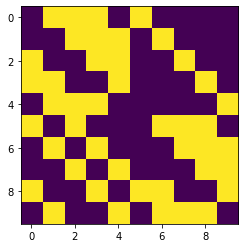

In [12]:
dataset = Stochastic2()
data = dataset[0]
# visualize_graph(data)
visualize_heatmap(data.edge_index)

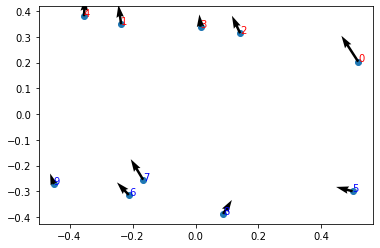

In [13]:
sparse_A = torch.sparse_coo_tensor(data.edge_index, torch.ones(data.edge_index.shape[1]))
A = sparse_A.to_dense()
A = A.numpy()
A = np.ndarray.tolist(A)

coords, density, fields = UW_directed_embedding(A, 2)
visualize_UW_dir_emb(coords, density, fields)
for i in range(int(len(coords)/2)):
    plt.text(coords[i][0], coords[i][1], i, color = "red")
for i in range(int(len(coords)/2), len(coords)):
    plt.text(coords[i][0], coords[i][1], i, color = "blue")

In [14]:
class Stochastic3(InMemoryDataset):
  def __init__(self,num_nodes = 10,transform=None):
    super().__init__(".", transform)
    dense_adj = torch.tensor(
      [[0,1,1,1,0,0,0,0,0,0],
      [0,0,1,1,1,0,0,0,0,0],
      [1,0,0,1,1,0,0,0,0,0],
      [1,1,0,0,1,0,0,0,0,0],
      [0,1,1,1,0,0,0,0,0,0],
      [1,0,1,0,0,0,1,1,1,0],
      [0,1,0,1,0,0,0,1,1,1],
      [0,0,1,0,1,0,0,0,1,1],
      [1,0,0,1,0,1,1,0,0,1],
      [0,1,0,0,1,0,1,1,1,0]]
    )
    sparse_adj = SparseTensor.from_dense(dense_adj)
    row, col, _ = sparse_adj.coo()
    edge_index, _ = remove_self_loops(torch.stack([row, col]))

    x = torch.eye(num_nodes, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index)
    self.data, self.slices = self.collate([data])

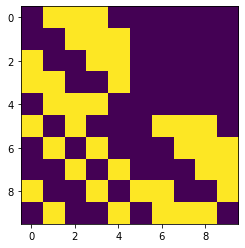

In [15]:
dataset = Stochastic3()
data = dataset[0]
# visualize_graph(data)
visualize_heatmap(data.edge_index)

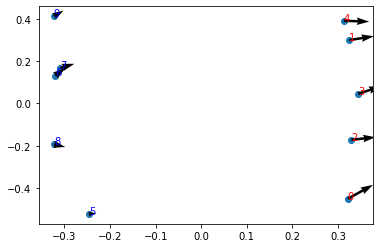

In [16]:
sparse_A = torch.sparse_coo_tensor(data.edge_index, torch.ones(data.edge_index.shape[1]))
A = sparse_A.to_dense()
A = A.numpy()
A = np.ndarray.tolist(A)

coords, density, fields = UW_directed_embedding(A, 2)
visualize_UW_dir_emb(coords, density, fields)
for i in range(int(len(coords)/2)):
    plt.text(coords[i][0], coords[i][1], i, color = "red")
for i in range(int(len(coords)/2), len(coords)):
    plt.text(coords[i][0], coords[i][1], i, color = "blue")

In [17]:
class Stochastic4(InMemoryDataset):
  def __init__(self,num_nodes = 10,transform=None):
    super().__init__(".", transform)
    dense_adj = torch.tensor(
      [[0,1,1,1,1,0,0,0,0,0],
      [1,0,1,1,1,0,0,0,0,0],
      [1,1,0,1,1,0,0,0,0,0],
      [1,1,1,0,1,0,0,0,0,0],
      [1,1,1,1,0,0,0,0,0,0],
      [1,0,1,0,0,0,1,1,1,0],
      [0,1,0,1,0,0,0,1,1,1],
      [0,0,1,0,1,0,0,0,1,1],
      [1,0,0,1,0,1,1,0,0,1],
      [0,1,0,0,1,0,1,1,1,0]]
    )
    sparse_adj = SparseTensor.from_dense(dense_adj)
    row, col, _ = sparse_adj.coo()
    edge_index, _ = remove_self_loops(torch.stack([row, col]))

    x = torch.eye(num_nodes, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index)
    self.data, self.slices = self.collate([data])

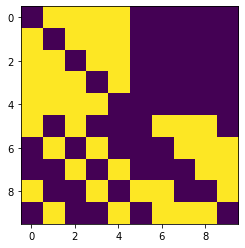

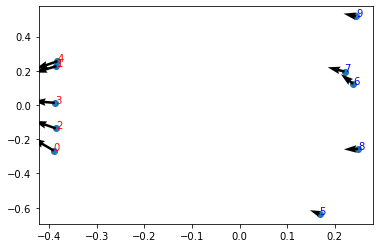

In [18]:
dataset = Stochastic4()
data = dataset[0]
# visualize_graph(data)
visualize_heatmap(data.edge_index)

sparse_A = torch.sparse_coo_tensor(data.edge_index, torch.ones(data.edge_index.shape[1]))
A = sparse_A.to_dense()
A = A.numpy()
A = np.ndarray.tolist(A)

coords, density, fields = UW_directed_embedding(A, 2)
visualize_UW_dir_emb(coords, density, fields)
for i in range(int(len(coords)/2)):
    plt.text(coords[i][0], coords[i][1], i, color = "red")
for i in range(int(len(coords)/2), len(coords)):
    plt.text(coords[i][0], coords[i][1], i, color = "blue")

### Bigger Stochastic Model

In [19]:
import random
from decimal import Decimal

In [20]:
num_nodes = 40
W = [[0 for y in range(num_nodes)] for x in range(num_nodes)]

for i in range(int(num_nodes/2)):
    for j in range(int(num_nodes/2)):
        if Decimal(random.random()) < .75:
            W[i][j] = 1
    for j in range(int(num_nodes/2), num_nodes):
        if Decimal(random.random()) < .25:
            W[i][j] = 1

for i in range(int(num_nodes/2), num_nodes):
    for j in range(int(num_nodes/2)):
        if Decimal(random.random()) < .5:
            W[i][j] = 1
    for j in range(int(num_nodes/2), num_nodes):
        if Decimal(random.random()) < .75:
            W[i][j] = 1

class StochasticBig(InMemoryDataset):
  def __init__(self,num_nodes = 10,transform=None):
    super().__init__(".", transform)
    
    dense_adj = torch.tensor(W)
    sparse_adj = SparseTensor.from_dense(dense_adj)
    row, col, _ = sparse_adj.coo()
    edge_index, _ = remove_self_loops(torch.stack([row, col]))

    x = torch.eye(num_nodes, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index)
    self.data, self.slices = self.collate([data])

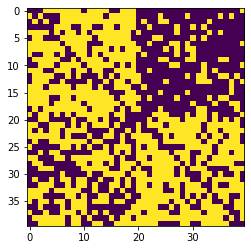

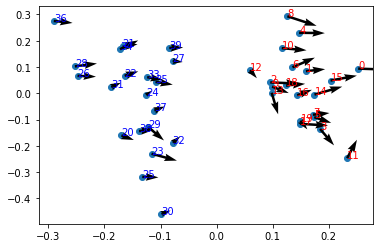

In [21]:
dataset = StochasticBig()
data = dataset[0]
# visualize_graph(data)
visualize_heatmap(data.edge_index)

sparse_A = torch.sparse_coo_tensor(data.edge_index, torch.ones(data.edge_index.shape[1]))
A = sparse_A.to_dense()
A = A.numpy()
A = np.ndarray.tolist(A)

coords, density, fields = UW_directed_embedding(A, 2)
visualize_UW_dir_emb(coords, density, fields)
for i in range(int(len(coords)/2)):
    plt.text(coords[i][0], coords[i][1], i, color = "red")
for i in range(int(len(coords)/2), len(coords)):
    plt.text(coords[i][0], coords[i][1], i, color = "blue")

In [22]:
num_nodes = 200
W = [[0 for y in range(num_nodes)] for x in range(num_nodes)]

for i in range(int(num_nodes/2)):
    for j in range(int(num_nodes/2)):
        if Decimal(random.random()) < .75:
            W[i][j] = 1
    for j in range(int(num_nodes/2), num_nodes):
        if Decimal(random.random()) < .25:
            W[i][j] = 1

for i in range(int(num_nodes/2), num_nodes):
    for j in range(int(num_nodes/2)):
        if Decimal(random.random()) < .5:
            W[i][j] = 1
    for j in range(int(num_nodes/2), num_nodes):
        if Decimal(random.random()) < .75:
            W[i][j] = 1

class StochasticHuge(InMemoryDataset):
  def __init__(self,num_nodes = 10,transform=None):
    super().__init__(".", transform)
    
    dense_adj = torch.tensor(W)
    sparse_adj = SparseTensor.from_dense(dense_adj)
    row, col, _ = sparse_adj.coo()
    edge_index, _ = remove_self_loops(torch.stack([row, col]))

    x = torch.eye(num_nodes, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index)
    self.data, self.slices = self.collate([data])

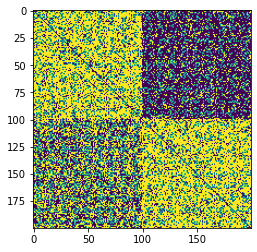

'\nfor i in range(int(len(coords)/2)):\n    plt.text(coords[i][0], coords[i][1], i, color = "red")\nfor i in range(int(len(coords)/2), len(coords)):\n    plt.text(coords[i][0], coords[i][1], i, color = "blue")\n'

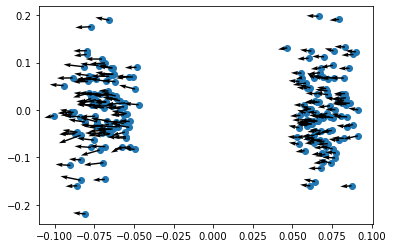

In [23]:
dataset = StochasticHuge()
data = dataset[0]
# visualize_graph(data)
visualize_heatmap(data.edge_index)

sparse_A = torch.sparse_coo_tensor(data.edge_index, torch.ones(data.edge_index.shape[1]))
A = sparse_A.to_dense()
A = A.numpy()
A = np.ndarray.tolist(A)

coords, density, fields = UW_directed_embedding(A, 2)
visualize_UW_dir_emb(coords, density, fields)
"""
for i in range(int(len(coords)/2)):
    plt.text(coords[i][0], coords[i][1], i, color = "red")
for i in range(int(len(coords)/2), len(coords)):
    plt.text(coords[i][0], coords[i][1], i, color = "blue")
"""    

### Two Cluster, no direction

In [24]:
num_nodes = 100
W = [[0 for y in range(num_nodes)] for x in range(num_nodes)]

for i in range(int(num_nodes/2)):
    for j in range(int(num_nodes/2)):
        if Decimal(random.random()) < .75:
            W[i][j] = 1
    for j in range(int(num_nodes/2), num_nodes):
        if Decimal(random.random()) < .3:
            W[i][j] = 1

for i in range(int(num_nodes/2), num_nodes):
    for j in range(int(num_nodes/2)):
        if Decimal(random.random()) < .3:
            W[i][j] = 1
    for j in range(int(num_nodes/2), num_nodes):
        if Decimal(random.random()) < .75:
            W[i][j] = 1

class TwoClustNoDirection(InMemoryDataset):
  def __init__(self,num_nodes = 10,transform=None):
    super().__init__(".", transform)
    
    dense_adj = torch.tensor(W)
    sparse_adj = SparseTensor.from_dense(dense_adj)
    row, col, _ = sparse_adj.coo()
    edge_index, _ = remove_self_loops(torch.stack([row, col]))

    x = torch.eye(num_nodes, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index)
    self.data, self.slices = self.collate([data])

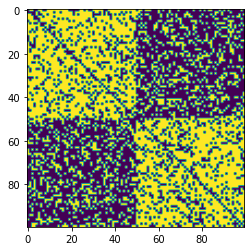

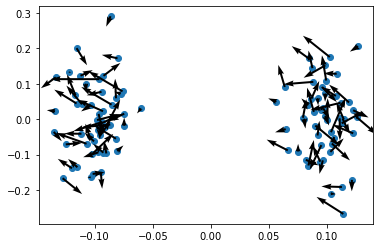

In [25]:
dataset = TwoClustNoDirection()
data = dataset[0]
# visualize_graph(data)
visualize_heatmap(data.edge_index)

sparse_A = torch.sparse_coo_tensor(data.edge_index, torch.ones(data.edge_index.shape[1]))
A = sparse_A.to_dense()
A = A.numpy()
A = np.ndarray.tolist(A)

coords, density, fields = UW_directed_embedding(A, 2)
visualize_UW_dir_emb(coords, density, fields)

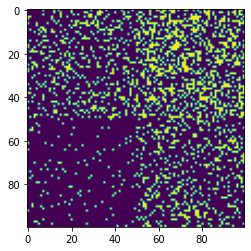

In [26]:
from directed_graphs.datasets import DirectedStochasticBlockModel
aij = np.array([[0.4,0.4],[0.4,0.4]])
bij = np.array([[0.5,0.9],[0.1,0.5]])
dataset = DirectedStochasticBlockModel(num_nodes=100, num_clusters=2, aij = aij, bij = bij)
data = dataset[0] # there is only graph in this dataset
sparse_A = torch.sparse_coo_tensor(data.edge_index,torch.ones(data.edge_index.shape[1]))
A = sparse_A.to_dense()
plt.imshow(A)

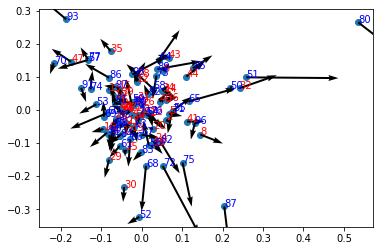

In [27]:
sparse_A = torch.sparse_coo_tensor(data.edge_index, torch.ones(data.edge_index.shape[1]))
A = sparse_A.to_dense()
A = A.numpy()
A = np.ndarray.tolist(A)

coords, density, fields = UW_directed_embedding(A, 2)
visualize_UW_dir_emb(coords, density, fields)
for i in range(int(len(coords)/2)):
    plt.text(coords[i][0], coords[i][1], i, color = "red")
for i in range(int(len(coords)/2), len(coords)):
    plt.text(coords[i][0], coords[i][1], i, color = "blue")

### Three Stohastic Model

In [28]:
num_nodes = 300
W = [[0 for y in range(num_nodes)] for x in range(num_nodes)]

for i in range(int(num_nodes/3)):
    for j in range(int(num_nodes/3)):
        if Decimal(random.random()) < .75:
            W[i][j] = 1
    for j in range(int(num_nodes/3), 2*int(num_nodes/3)):
        if Decimal(random.random()) < 0.5:
            W[i][j] = 1
    for j in range(2*int(num_nodes/3), num_nodes):
        if Decimal(random.random()) < 0.25:
            W[i][j] = 1

for i in range(int(num_nodes/3), 2*int(num_nodes/3)):
    for j in range(int(num_nodes/3)):
        if Decimal(random.random()) < .25:
            W[i][j] = 1
    for j in range(int(num_nodes/3), 2*int(num_nodes/3)):
        if Decimal(random.random()) < .75:
            W[i][j] = 1
    for j in range(2*int(num_nodes/3), num_nodes):
        if Decimal(random.random()) < 0.5:
            W[i][j] = 1

for i in range(2*int(num_nodes/3), num_nodes):
    for j in range(int(num_nodes/3)):
        if Decimal(random.random()) < 0.5:
            W[i][j] = 1
    for j in range(int(num_nodes/3), 2*int(num_nodes/3)):
        if Decimal(random.random()) < .25:
            W[i][j] = 1
    for j in range(2*int(num_nodes/3), num_nodes):
        if Decimal(random.random()) < .75:
            W[i][j] = 1

class Stochastic3(InMemoryDataset):
  def __init__(self,num_nodes = 10,transform=None):
    super().__init__(".", transform)
    
    dense_adj = torch.tensor(W)
    sparse_adj = SparseTensor.from_dense(dense_adj)
    row, col, _ = sparse_adj.coo()
    edge_index, _ = remove_self_loops(torch.stack([row, col]))

    x = torch.eye(num_nodes, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index)
    self.data, self.slices = self.collate([data])

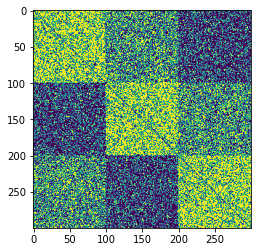

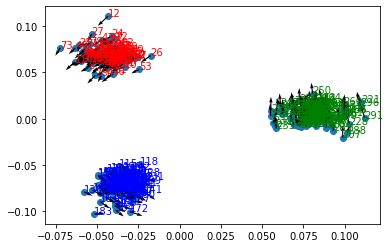

In [29]:
dataset = Stochastic3()
data = dataset[0]
# visualize_graph(data)
visualize_heatmap(data.edge_index)

sparse_A = torch.sparse_coo_tensor(data.edge_index, torch.ones(data.edge_index.shape[1]))
A = sparse_A.to_dense()
A = A.numpy()
A = np.ndarray.tolist(A)

coords, density, fields = UW_directed_embedding(A, 2)
visualize_UW_dir_emb(coords, density, fields)
for i in range(int(len(coords)/3)):
    plt.text(coords[i][0], coords[i][1], i, color = "red")
for i in range(int(len(coords)/3), 2*int(len(coords)/3)):
    plt.text(coords[i][0], coords[i][1], i, color = "blue")
for i in range(2*int(len(coords)/3), len(coords)):
    plt.text(coords[i][0], coords[i][1], i, color = "green")

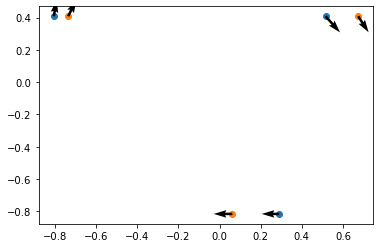

In [30]:
W = [[0.75, 0.5, 0.25],
     [0.25, 0.75, 0.5],
     [0.5, 0.25, 0.75]]

coords, density, fields = UW_directed_embedding(W, 2)

visualize_UW_dir_emb(coords, density, fields)

W = [[0, 1, 0],
     [0, 0, 1],
     [1, 0, 0]]

coords, density, fields = UW_directed_embedding(W, 2)

visualize_UW_dir_emb(coords, density, fields)

### Three-node cycle Meta graph

In [31]:
num_nodes = 300
W = [[0 for y in range(num_nodes)] for x in range(num_nodes)]

for i in range(int(num_nodes/3)):
    for j in range(int(num_nodes/3)):
        if Decimal(random.random()) < .99:
            W[i][j] = 1
    for j in range(int(num_nodes/3), 2*int(num_nodes/3)):
        if Decimal(random.random()) < .99:
            W[i][j] = 1
    for j in range(2*int(num_nodes/3), num_nodes):
        if Decimal(random.random()) < 0:
            W[i][j] = 1

for i in range(int(num_nodes/3), 2*int(num_nodes/3)):
    for j in range(int(num_nodes/3)):
        if Decimal(random.random()) < 0:
            W[i][j] = 1
    for j in range(int(num_nodes/3), 2*int(num_nodes/3)):
        if Decimal(random.random()) < .99:
            W[i][j] = 1
    for j in range(2*int(num_nodes/3), num_nodes):
        if Decimal(random.random()) < .99:
            W[i][j] = 1

for i in range(2*int(num_nodes/3), num_nodes):
    for j in range(int(num_nodes/3)):
        if Decimal(random.random()) < .99:
            W[i][j] = 1
    for j in range(int(num_nodes/3), 2*int(num_nodes/3)):
        if Decimal(random.random()) < 0:
            W[i][j] = 1
    for j in range(2*int(num_nodes/3), num_nodes):
        if Decimal(random.random()) < .99:
            W[i][j] = 1

class ThreeNodeCycle(InMemoryDataset):
  def __init__(self,num_nodes = 10,transform=None):
    super().__init__(".", transform)
    
    dense_adj = torch.tensor(W)
    sparse_adj = SparseTensor.from_dense(dense_adj)
    row, col, _ = sparse_adj.coo()
    edge_index, _ = remove_self_loops(torch.stack([row, col]))

    x = torch.eye(num_nodes, dtype=torch.float)
    data = Data(x=x, edge_index=edge_index)
    self.data, self.slices = self.collate([data])

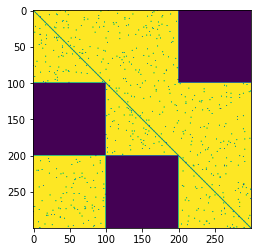

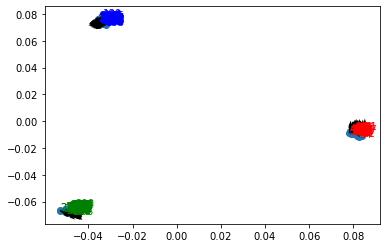

In [32]:
dataset = ThreeNodeCycle()
data = dataset[0]
# visualize_graph(data)
visualize_heatmap(data.edge_index)

sparse_A = torch.sparse_coo_tensor(data.edge_index, torch.ones(data.edge_index.shape[1]))
A = sparse_A.to_dense()
A = A.numpy()
A = np.ndarray.tolist(A)

coords, density, fields = UW_directed_embedding(A, 2)
visualize_UW_dir_emb(coords, density, fields)
for i in range(int(len(coords)/3)):
    plt.text(coords[i][0], coords[i][1], i, color = "red")
for i in range(int(len(coords)/3), 2*int(len(coords)/3)):
    plt.text(coords[i][0], coords[i][1], i, color = "blue")
for i in range(2*int(len(coords)/3), len(coords)):
    plt.text(coords[i][0], coords[i][1], i, color = "green")

In [33]:
print(np.average(fields[:100,0]))
print(np.average(fields[:100,1]))
print(np.average(fields[100:200,0]))
print(np.average(fields[100:200,1]))
print(np.average(fields[200:300,0]))
print(np.average(fields[200:300,1]))

9.475172709127658e-08
9.102698120549535e-07
-8.357359474507468e-07
-3.733950954688855e-07
7.40824621722915e-07
-5.385562614697594e-07
